# Example 07 - TorchSig Narrowband with YOLOv8 Classifier
This notebook showcases using the TorchSig Narrowband dataset to train a YOLOv8 classification model.

---

## Import Libraries

In [1]:
# Packages for Training
from torchsig.utils.yolo_classify import *
from torchsig.utils.classify_transforms import real_imag_vstacked_cwt_image, complex_iq_to_heatmap
import yaml

In [2]:
# Packages for testing/inference
from torchsig.datasets.modulations import ModulationsDataset
from torchsig.datasets.signal_classes import torchsig_signals
from torchsig.transforms.target_transforms import DescToFamilyName
from torchsig.transforms.transforms import Spectrogram, SpectrogramImage, Normalize, Compose, Identity
from ultralytics import YOLO
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os

## Prepare YOLO classificatoin trainer and Model
Datasets are generated on the fly in a way that is Ultralytics YOLO compatible. See [Ultralytics: Train Custom Data - Organize Directories](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#23-organize-directories) to learn more. 

Additionally, we create a yaml file for dataset configuration. See "07_yolo.yaml" in Torchsig Examples.

Download desired YOLO model from [Ultralytics Models](https://docs.ultralytics.com/models/). We will use YOLOv8, specifically `yolov8n-cls.pt`

---

In [3]:
config_path = '07_yolo.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

overrides = config['overrides']

### Explanation of the `overrides` Dictionary

The `overrides` dictionary is used to customize the settings for the Ultralytics YOLO trainer by specifying specific values that override the default configurations. The dictionary is imported from `07_yolo.yaml`. However, you can customize in the notebook. 

Example:

```python
overrides = {'model': 'yolov8n-cls.pt', 'epochs': 100, 'data': '07_yolo.yaml', 'device': 0, 'imgsz': 64}
```
A .yaml is necessary for training. Look at `07_yolo.yaml` in the examples directory. It will contain the path to your torchsig data.

### Explanation of `image_transform` function
`YoloClassifyTrainer` allows you to pass in any transform that takes in complex I/Q and outputs an image for training. Some example transforms can be found in torchsig.utils.classify_transforms. If nothing is passed, it will default to spectrogram images. It is important to update `overrides` so that your imgsz matches output.

In [4]:
# define dataset variables for yaml file
config_name = "07_yolo.yaml"
family_list = ["ask", "fsk", "ofdm", "pam", "psk", "qam"]
family_dict = {v: k for v, k in enumerate(family_list)}
classes = {v: k for v, k in enumerate(torchsig_signals.class_list)}
num_classes = len(classes)
yolo_root = "./wideband/" # train/val images (relative to './datasets``

# define overrides
overrides = dict(
    model = "yolov8n-cls.pt",
    project = "yolo",
    name = "07_example",
    epochs = 5,
    imgsz = 512,
    data = config_name,
    device = 0 if torch.cuda.is_available() else "cpu",
    batch = 32,
    workers = 8

)

# create yaml file for trainer
yolo_config = dict(
    overrides = overrides,
    train = yolo_root,
    val = yolo_root,
    level = 2,
    include_snr = False,
    num_samples = 610,
    nc = num_classes,
    names = classes,
    family = False, # Determines if you are classify all 50+ classes or modulation family (see Classes below)
    families = family_dict
)

with open(config_name, 'w+') as file:
    yaml.dump(yolo_config, file, default_flow_style=False)

print(f"Creating experiment -> {overrides['name']}")

Creating experiment -> 07_example


### Build YoloClassifyTrainer
This will instantiate the YOLO classification trainer with overrides specified above.

In [5]:
trainer = YoloClassifyTrainer(overrides=overrides, image_transform=None)

Ultralytics 8.3.58 🚀 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81038MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=07_yolo.yaml, epochs=5, time=None, patience=100, batch=32, imgsz=512, save=True, save_period=-1, cache=False, device=0, workers=8, project=yolo, name=07_example, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

### Then begin training

In [6]:
trainer.train()

100%|██████████| 5.31M/5.31M [00:00<00:00, 9.53MB/s]


Overriding model.yaml nc=1000 with nc=61

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralyt

100%|██████████| 5.35M/5.35M [00:00<00:00, 15.6MB/s]


AMP: checks passed ✅
mode -> train
mode -> val
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


2025/01/31 16:00:26 INFO mlflow.tracking.fluent: Experiment with name 'yolo' does not exist. Creating a new experiment.


MLflow: logging run_id(7c1a03227a17404184d1e26f723f4fc2) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to yolo/07_example
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


        1/5      1.95G      4.216         32        512:   5%|▌         | 1/20 [00:23<07:26, 23.50s/it]

100%|██████████| 755k/755k [00:00<00:00, 15.5MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]

                   all     0.0328     0.0656



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 46.53it/s]

                   all     0.0328      0.082



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s]

                   all     0.0492      0.115



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 54.23it/s]

                   all     0.0492      0.148



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 32.28it/s]


                   all     0.0656       0.18

5 epochs completed in 0.075 hours.
Optimizer stripped from yolo/07_example/weights/last.pt, 3.1MB
Optimizer stripped from yolo/07_example/weights/best.pt, 3.1MB

Validating yolo/07_example/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81038MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,513,021 parameters, 0 gradients, 3.4 GFLOPs


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 44.19it/s]


                   all     0.0492       0.18
Speed: 0.1ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to yolo/07_example
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


### Instantiate Test Dataset

Uses Torchsig's `ModulationsDataset` to generate a narrowband classification dataset. 

In [7]:
# Determine whether to map descriptions to family names
if config['family']:
    target_transform = CP([DescToFamilyName()])
else:
    target_transform = None

transform = Compose([
    Spectrogram(nperseg=overrides['imgsz'], noverlap=0, nfft=overrides['imgsz'], mode='psd'),
    Normalize(norm=np.inf, flatten=True),
    SpectrogramImage(), 
    ])

class_list = [item[1] for item in config['names'].items()]

dataset = ModulationsDataset(
    classes=class_list,
    use_class_idx=False,
    level=config['level'],
    num_iq_samples=overrides['imgsz']**2,
    num_samples=int(config['nc'] * 10),
    include_snr=config['include_snr'],
    transform=transform,
    target_transform=target_transform
)

# Retrieve a sample and print out information
idx = np.random.randint(len(dataset))
data, label = dataset[idx]
print("Dataset length: {}".format(len(dataset)))
print("Data shape: {}".format(data.shape))

samples = []
labels = []
for i in range(10):
    idx = np.random.randint(len(dataset))
    sample, label = dataset[idx]
    samples.append(sample)
    labels.append(label)

Dataset length: 610
Data shape: (512, 512, 3)


### Predictions / Inference
The following cells show you how to load the 'best.pt' weights from your training for prediction

In [8]:
%matplotlib inline

In [9]:
model = YOLO(trainer.best) #The model will remember the configuration from training
results = model.predict(samples, save=True)


0: 512x512 32ask 0.03, qpsk 0.03, 64qam 0.02, 8psk 0.02, 2fsk 0.02, 9.0ms
1: 512x512 qpsk 0.03, 32ask 0.03, 64qam 0.03, 8psk 0.03, am-dsb 0.02, 9.0ms
2: 512x512 ofdm-512 0.03, ofdm-300 0.03, ofdm-72 0.03, ook 0.03, 2fsk 0.03, 9.0ms
3: 512x512 ofdm-300 0.03, ofdm-512 0.03, ofdm-128 0.03, qpsk 0.03, 64qam 0.03, 9.0ms
4: 512x512 ofdm-1024 0.03, 8psk 0.03, ofdm-72 0.03, qpsk 0.03, ofdm-128 0.03, 9.0ms
5: 512x512 am-dsb 0.03, qpsk 0.03, 2fsk 0.03, 1024qam 0.03, 32ask 0.03, 9.0ms
6: 512x512 qpsk 0.03, 64qam 0.03, 8psk 0.03, am-dsb 0.03, ofdm-128 0.02, 9.0ms
7: 512x512 qpsk 0.04, 8psk 0.03, ofdm-300 0.03, 64qam 0.03, am-dsb 0.02, 9.0ms
8: 512x512 qpsk 0.04, 32ask 0.03, 8psk 0.03, am-dsb 0.03, 64qam 0.03, 9.0ms
9: 512x512 am-dsb 0.03, qpsk 0.03, 8psk 0.03, 2fsk 0.03, 64qam 0.02, 9.0ms
Speed: 385.5ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/classify/predict


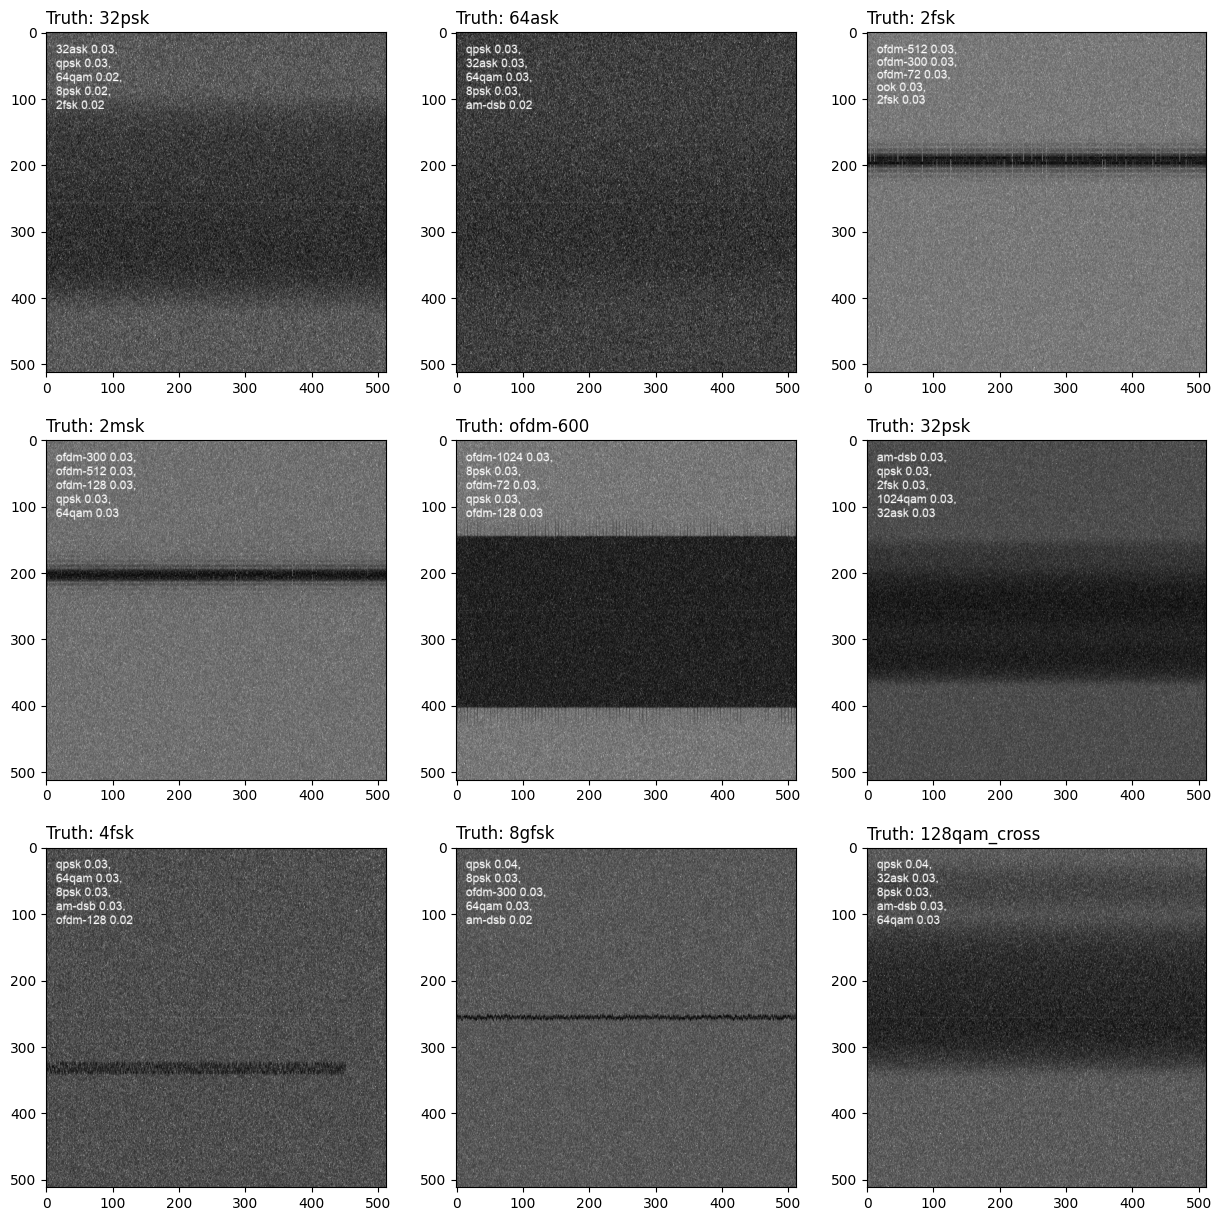

In [10]:
# Plot prediction results
# Note: do not expect significant detections with illustrative default parameters. 
rows = 3
cols = 3
fig = plt.figure(figsize=(15, 15)) 
results_dir = results[0].save_dir

for y, result in enumerate(results[:9]):
    imgpath = os.path.join(results_dir, "image" + str(y) + ".jpg")
    fig.add_subplot(rows, cols, y + 1) 
    img = cv2.imread(imgpath)
    plt.imshow(img)
    plt.title("Truth: " + str(labels[y]), fontsize='large', loc='left')
